In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 7000
embedding_dim = 256
max_length = 30
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [3]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "while", "with", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"]
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~\n'''

In [4]:
category = []
subcategory = []
questions = []

with open('train_5500.label', 'r') as f:
    for line in f:
        split_index1 = line.index(":")
        split_index2 = line.index(" ")
        category.append(line[:split_index1])
        subcategory.append(line[split_index1+1:split_index2])
        questions.append(line[(split_index2+1):])
        
print(category[0])
print(subcategory[0])
print(questions[0])

DESC
manner
How did serfdom develop in and then leave Russia ?



In [5]:
for i in range(0,len(questions)):
    question = questions[i].lower()
    for word in stopwords:
        token = " " + word + " "
        question = question.replace(token, " ")
    no_punct = ''
    for char in question:
        if char not in punctuations:
            no_punct = no_punct + char
    questions[i] = no_punct

print(len(category))
print(len(questions))
print(questions[0:10])

5452
5452
['how serfdom develop leave russia ', 'what films featured character popeye doyle ', 'how can find list celebrities  real names ', 'what fowl grabs spotlight chinese year monkey ', 'what full form com ', 'what contemptible scoundrel stole cork lunch ', 'what team baseball s st louis browns become ', 'what oldest profession ', 'what liver enzymes ', 'name scarfaced bounty hunter old west ']


In [6]:
train_size = int(len(questions) * training_portion)

train_questions = questions[:train_size]
train_category = category[:train_size]
train_subcategory = subcategory[:train_size]

validation_questions = questions[train_size:]
validation_category = category[train_size:]
validation_subcategory = subcategory[train_size:]

print(train_size)
print(len(train_questions))
print(len(train_category))
print(len(validation_questions))
print(len(validation_category))

4361
4361
4361
1091
1091


In [7]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_questions)
word_index = tokenizer.word_index
print(len(word_index))

train_sequences = tokenizer.texts_to_sequences(train_questions)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

7446
5
30
6
30


In [8]:
validation_sequences = tokenizer.texts_to_sequences(validation_questions)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

1091
(1091, 30)


In [9]:
category_tokenizer = Tokenizer()
category_tokenizer.fit_on_texts(category)

training_category_seq = pad_sequences(np.array(category_tokenizer.texts_to_sequences(train_category)), maxlen=1)
validation_category_seq = pad_sequences(np.array(category_tokenizer.texts_to_sequences(validation_category)), maxlen=1)

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
#    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(60, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 256)           1792000   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 60)                7740      
Total params: 1,832,636
Trainable params: 1,832,636
Non-trainable params: 0
_________________________________________________________________


In [20]:
num_epochs = 10
history = model.fit(train_padded, training_category_seq, epochs = num_epochs, validation_data=(validation_padded, validation_category_seq), verbose = 2)

Train on 4361 samples, validate on 1091 samples
Epoch 1/10
4361/4361 - 17s - loss: 2.2225 - acc: 0.2185 - val_loss: 1.6384 - val_acc: 0.2209
Epoch 2/10
4361/4361 - 12s - loss: 1.6011 - acc: 0.2974 - val_loss: 1.5277 - val_acc: 0.3969
Epoch 3/10
4361/4361 - 12s - loss: 1.3721 - acc: 0.5547 - val_loss: 1.2057 - val_acc: 0.5784
Epoch 4/10
4361/4361 - 12s - loss: 0.9675 - acc: 0.7565 - val_loss: 0.8869 - val_acc: 0.7122
Epoch 5/10
4361/4361 - 10s - loss: 0.6070 - acc: 0.8615 - val_loss: 0.7126 - val_acc: 0.7544
Epoch 6/10
4361/4361 - 7s - loss: 0.3834 - acc: 0.9138 - val_loss: 0.6235 - val_acc: 0.7773
Epoch 7/10
4361/4361 - 7s - loss: 0.2604 - acc: 0.9395 - val_loss: 0.5824 - val_acc: 0.7910
Epoch 8/10
4361/4361 - 7s - loss: 0.1854 - acc: 0.9601 - val_loss: 0.5753 - val_acc: 0.7901
Epoch 9/10
4361/4361 - 11s - loss: 0.1374 - acc: 0.9677 - val_loss: 0.5940 - val_acc: 0.8020
Epoch 10/10
4361/4361 - 12s - loss: 0.1076 - acc: 0.9791 - val_loss: 0.5924 - val_acc: 0.8084


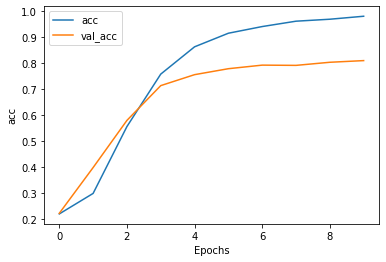

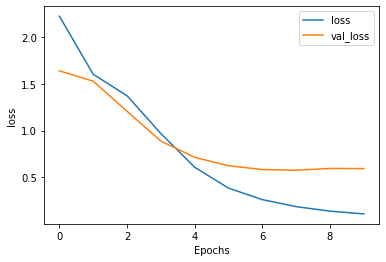

In [21]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [22]:
subcategory_tokenizer = Tokenizer()
subcategory_tokenizer.fit_on_texts(category)

training_subcategory_seq = pad_sequences(np.array(subcategory_tokenizer.texts_to_sequences(train_subcategory)), maxlen=1)
validation_subcategory_seq = pad_sequences(np.array(subcategory_tokenizer.texts_to_sequences(validation_subcategory)), maxlen=1)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
#    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(60, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 256)           1792000   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 60)                7740      
Total params: 1,832,636
Trainable params: 1,832,636
Non-trainable params: 0
_________________________________________________________________


In [27]:
num_epochs = 15
history = model.fit((train_padded, training_category_seq), training_subcategory_seq, epochs = num_epochs, validation_data=((validation_padded, validation_category_seq), validation_subcategory_seq), verbose = 2)

Train on 4361 samples, validate on 1091 samples
Epoch 1/15
4361/4361 - 8s - loss: 0.9578 - acc: 0.9333 - val_loss: 0.2211 - val_acc: 0.9441
Epoch 2/15
4361/4361 - 6s - loss: 0.2262 - acc: 0.9404 - val_loss: 0.2158 - val_acc: 0.9441
Epoch 3/15
4361/4361 - 5s - loss: 0.2170 - acc: 0.9404 - val_loss: 0.2103 - val_acc: 0.9441
Epoch 4/15
4361/4361 - 5s - loss: 0.2017 - acc: 0.9404 - val_loss: 0.1964 - val_acc: 0.9441
Epoch 5/15
4361/4361 - 5s - loss: 0.1663 - acc: 0.9413 - val_loss: 0.1652 - val_acc: 0.9450
Epoch 6/15
4361/4361 - 5s - loss: 0.1023 - acc: 0.9557 - val_loss: 0.1359 - val_acc: 0.9569
Epoch 7/15
4361/4361 - 5s - loss: 0.0500 - acc: 0.9837 - val_loss: 0.1303 - val_acc: 0.9615
Epoch 8/15
4361/4361 - 5s - loss: 0.0273 - acc: 0.9938 - val_loss: 0.1495 - val_acc: 0.9588
Epoch 9/15
4361/4361 - 5s - loss: 0.0167 - acc: 0.9972 - val_loss: 0.1458 - val_acc: 0.9588
Epoch 10/15
4361/4361 - 6s - loss: 0.0105 - acc: 0.9979 - val_loss: 0.1620 - val_acc: 0.9560
Epoch 11/15
4361/4361 - 5s - lo

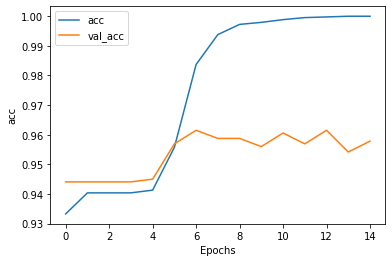

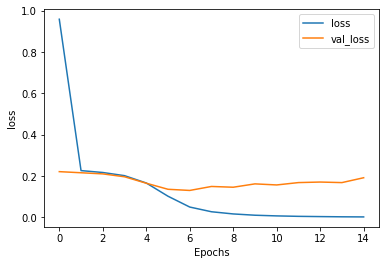

In [28]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")